# Higgs Machine Learning Challenge Example

This is an example solution to the Kaggle Higgs Machine learning challenge (https://www.kaggle.com/c/higgs-boson).

This script should serve as a starting point for learning how to get the data into some format appropriate for training a model on it. This example uses the popular Python packages Numpy and Pandas which should make your life easier. It also shows basic plotting with matplotlib and a machine learning model built using scikit-learn.

https://numpy.org/

https://pandas.pydata.org/

https://scikit-learn.org/stable/

First we will import the modules we are going to use, including code from the files Plotting and Tools found in the same directory as this file.

In [1]:
import pandas as pd
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import Plotting
import Tools
from joblib import dump, load

We will define a few functions to help us out later on.

In [2]:
def drop_neg(value):
    return value == -999.0

def get_class(value,cls):
    return value != cls

In [3]:
def calc_sep(sig,bkg,xvar='x'):
    return ((sig[xvar].mean()-bkg[xvar].mean())**2)/(sig[xvar].std()**2 + bkg[xvar].std()**2)

In [4]:
def visualisation_plots():
    df = pd.read_csv("train.csv")

    sig = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="s") ].index ).drop('Label',axis=1)
    bkg = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="b") ].index ).drop('Label',axis=1)

    sig_weights = sig.Weight.values
    bkg_weights = bkg.Weight.values

    sig = sig.drop('Weight',axis=1)
    bkg = bkg.drop('Weight',axis=1)
    sig = sig.drop('EventId',axis=1)
    bkg = bkg.drop('EventId',axis=1)
    sig = sig.drop('Unnamed: 0',axis=1)
    bkg = bkg.drop('Unnamed: 0',axis=1)
    
    separation_array = []
    for i in range(len(sig.columns)):
        Plotting.plot_hist(sig,bkg,sig.columns[i])
        separation_array.append([sig.columns[i],calc_sep(sig,bkg,sig.columns[i])])
        print("Separation for " + str(sig.columns[i]) + " is "+ str(calc_sep(sig,bkg,sig.columns[i])))
        
    print(np.matrix(sorted(separation_array,key=lambda x:x[1],reverse=True)))

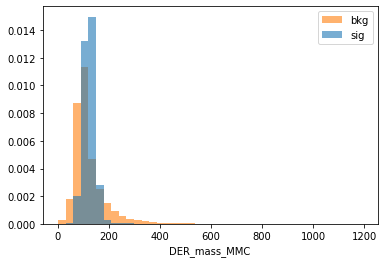

Separation for DER_mass_MMC is 0.16332745109582006


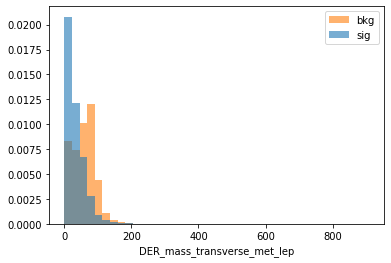

Separation for DER_mass_transverse_met_lep is 0.32280755267660766


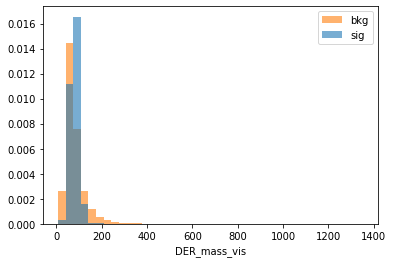

Separation for DER_mass_vis is 0.00033170765822746953


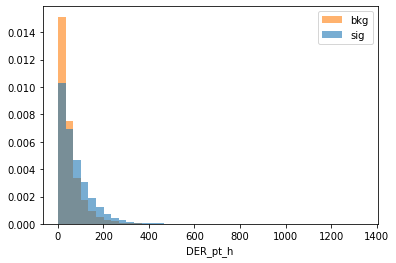

Separation for DER_pt_h is 0.07878559028258324


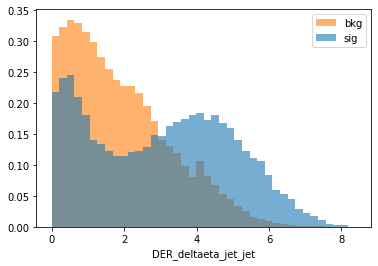

Separation for DER_deltaeta_jet_jet is 0.04365023360222267


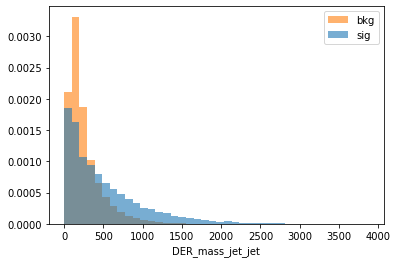

Separation for DER_mass_jet_jet is 0.07488670413459421


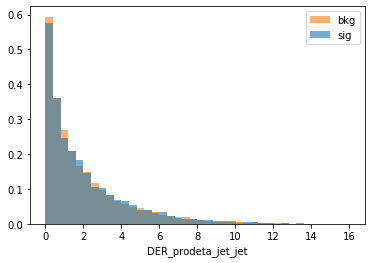

Separation for DER_prodeta_jet_jet is 0.043015465156049586


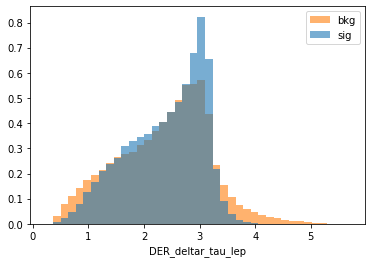

Separation for DER_deltar_tau_lep is 0.00029004170890339865


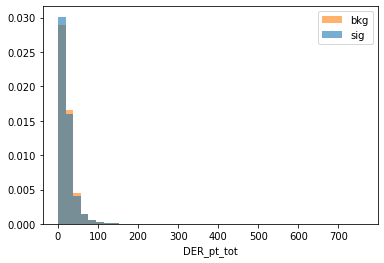

Separation for DER_pt_tot is 0.0006033113918329656


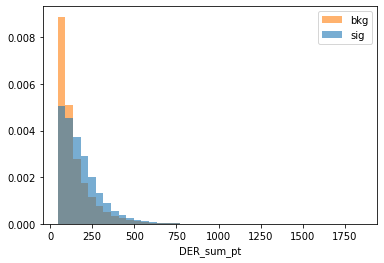

Separation for DER_sum_pt is 0.05249698472007502


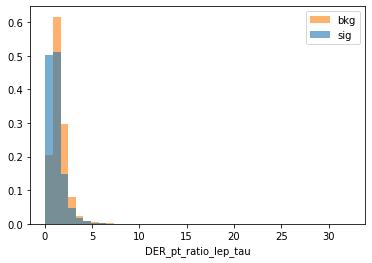

Separation for DER_pt_ratio_lep_tau is 0.09173941066119462


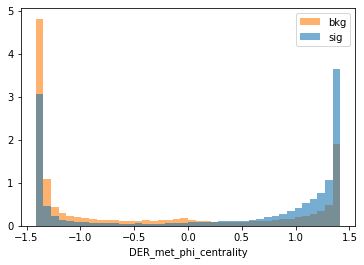

Separation for DER_met_phi_centrality is 0.17527389942782098


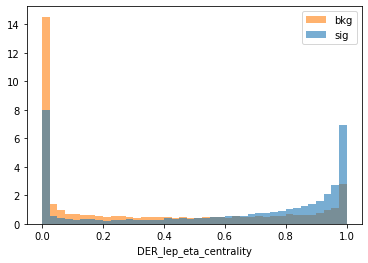

Separation for DER_lep_eta_centrality is 0.043476753013738656


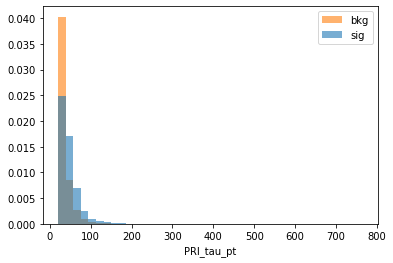

Separation for PRI_tau_pt is 0.1254996640010222


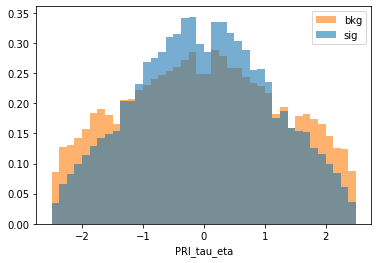

Separation for PRI_tau_eta is 5.7807900050598546e-06


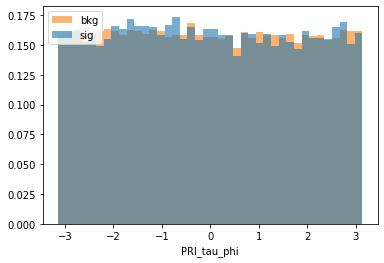

Separation for PRI_tau_phi is 2.0963880660324524e-06


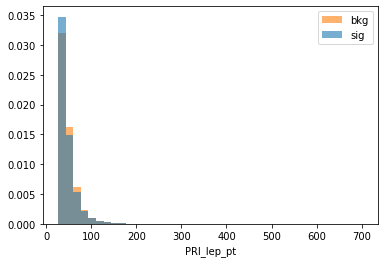

Separation for PRI_lep_pt is 0.0023136023249467133


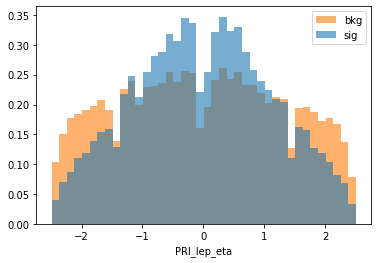

Separation for PRI_lep_eta is 7.926851328905185e-05


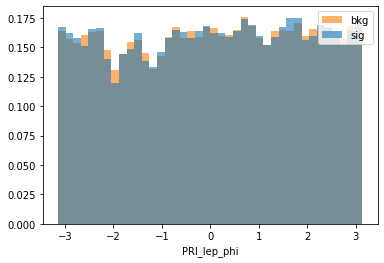

Separation for PRI_lep_phi is 7.309164185645731e-06


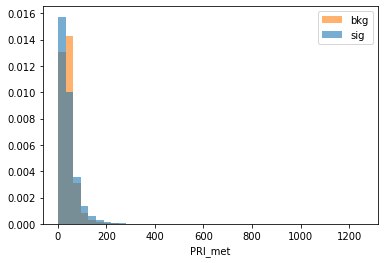

Separation for PRI_met is 0.0007964287657405583


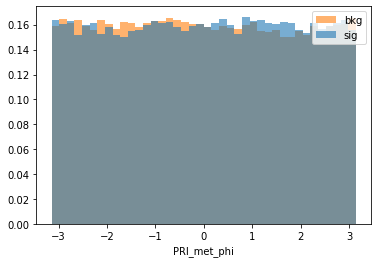

Separation for PRI_met_phi is 0.00010513235003353046


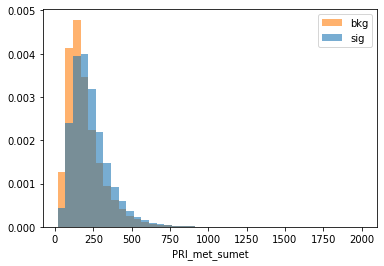

Separation for PRI_met_sumet is 0.04169710196046364


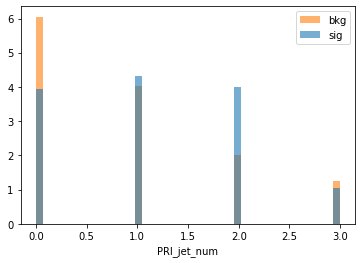

Separation for PRI_jet_num is 0.04169906299970917


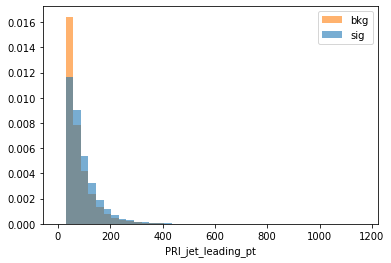

Separation for PRI_jet_leading_pt is 0.05917585944419749


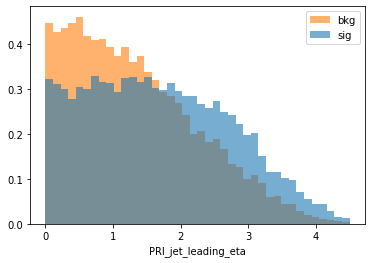

Separation for PRI_jet_leading_eta is 0.05435310756297604


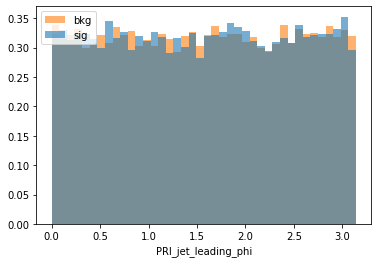

Separation for PRI_jet_leading_phi is 0.05435176257752762


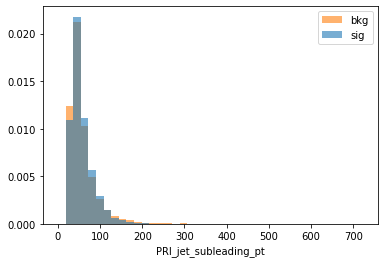

Separation for PRI_jet_subleading_pt is 0.043105360997595106


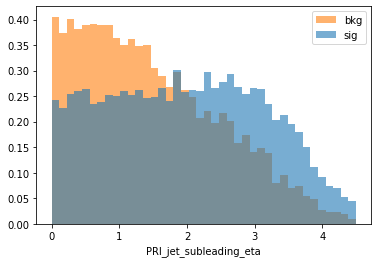

Separation for PRI_jet_subleading_eta is 0.04343616051981546


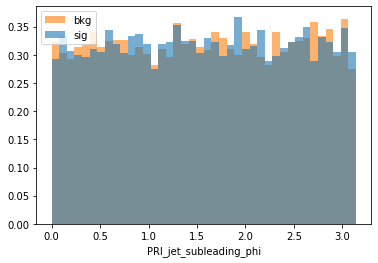

Separation for PRI_jet_subleading_phi is 0.043427336195834394


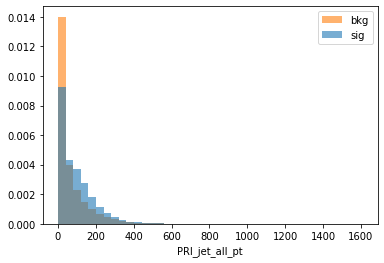

Separation for PRI_jet_all_pt is 0.04014800653166506
[['DER_mass_transverse_met_lep' '0.32280755267660766']
 ['DER_met_phi_centrality' '0.17527389942782098']
 ['DER_mass_MMC' '0.16332745109582006']
 ['PRI_tau_pt' '0.1254996640010222']
 ['DER_pt_ratio_lep_tau' '0.09173941066119462']
 ['DER_pt_h' '0.07878559028258324']
 ['DER_mass_jet_jet' '0.07488670413459421']
 ['PRI_jet_leading_pt' '0.05917585944419749']
 ['PRI_jet_leading_eta' '0.05435310756297604']
 ['PRI_jet_leading_phi' '0.05435176257752762']
 ['DER_sum_pt' '0.05249698472007502']
 ['DER_deltaeta_jet_jet' '0.04365023360222267']
 ['DER_lep_eta_centrality' '0.043476753013738656']
 ['PRI_jet_subleading_eta' '0.04343616051981546']
 ['PRI_jet_subleading_phi' '0.043427336195834394']
 ['PRI_jet_subleading_pt' '0.043105360997595106']
 ['DER_prodeta_jet_jet' '0.043015465156049586']
 ['PRI_jet_num' '0.04169906299970917']
 ['PRI_met_sumet' '0.04169710196046364']
 ['PRI_jet_all_pt' '0.04014800653166506']
 ['PRI_lep_pt' '0.0023136023249467133']

In [5]:
visualisation_plots()

## Correlation Matrix
The correlation between features can be plotted with df.corr().

In [6]:
def signal_correlations(**kwds):
    df = pd.read_csv("train.csv")

    sig = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="s") ].index ).drop('Label',axis=1)
    
    sig_weights = sig.Weight.values

    sig = sig.drop('Weight',axis=1)
    sig = sig.drop('EventId',axis=1)
    sig = sig.drop('Unnamed: 0',axis=1)
    
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = sig.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(20,18))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Signal Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

In [7]:
def background_correlations(**kwds):
    df = pd.read_csv("train.csv")

    bkg = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="b") ].index ).drop('Label',axis=1)

    bkg_weights = bkg.Weight.values

    bkg = bkg.drop('Weight',axis=1)
    bkg = bkg.drop('EventId',axis=1)
    bkg = bkg.drop('Unnamed: 0',axis=1)
    
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = bkg.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(20,18))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Background Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

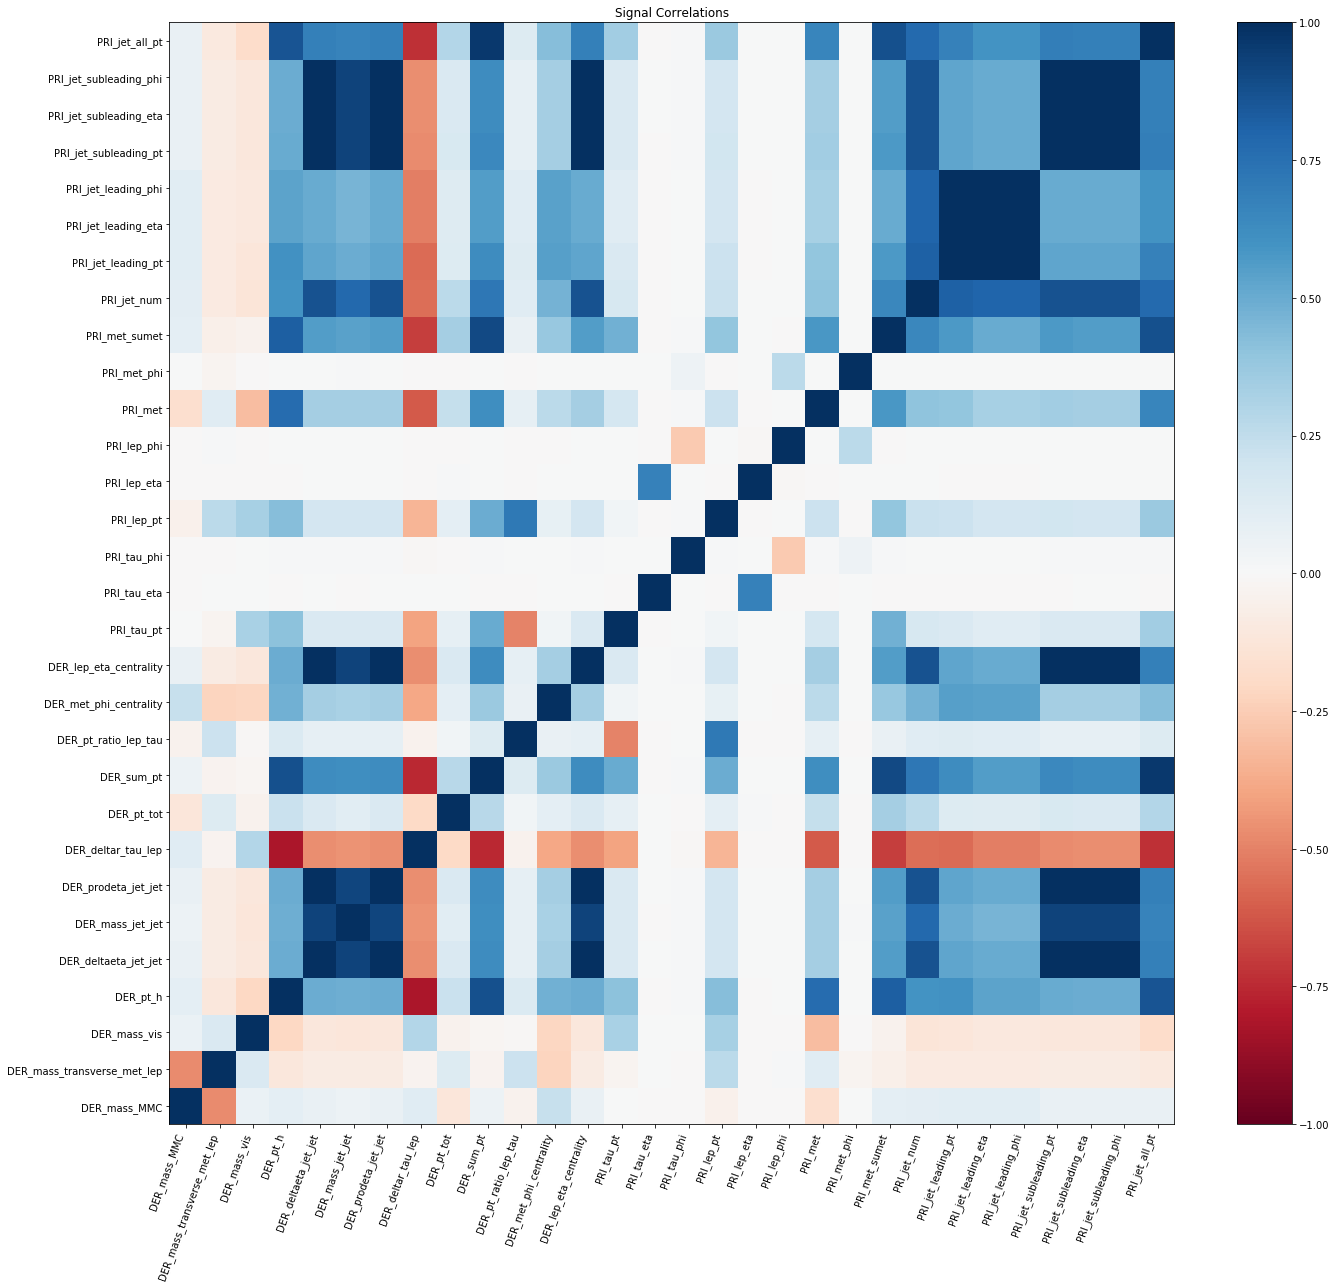

In [8]:
signal_correlations()

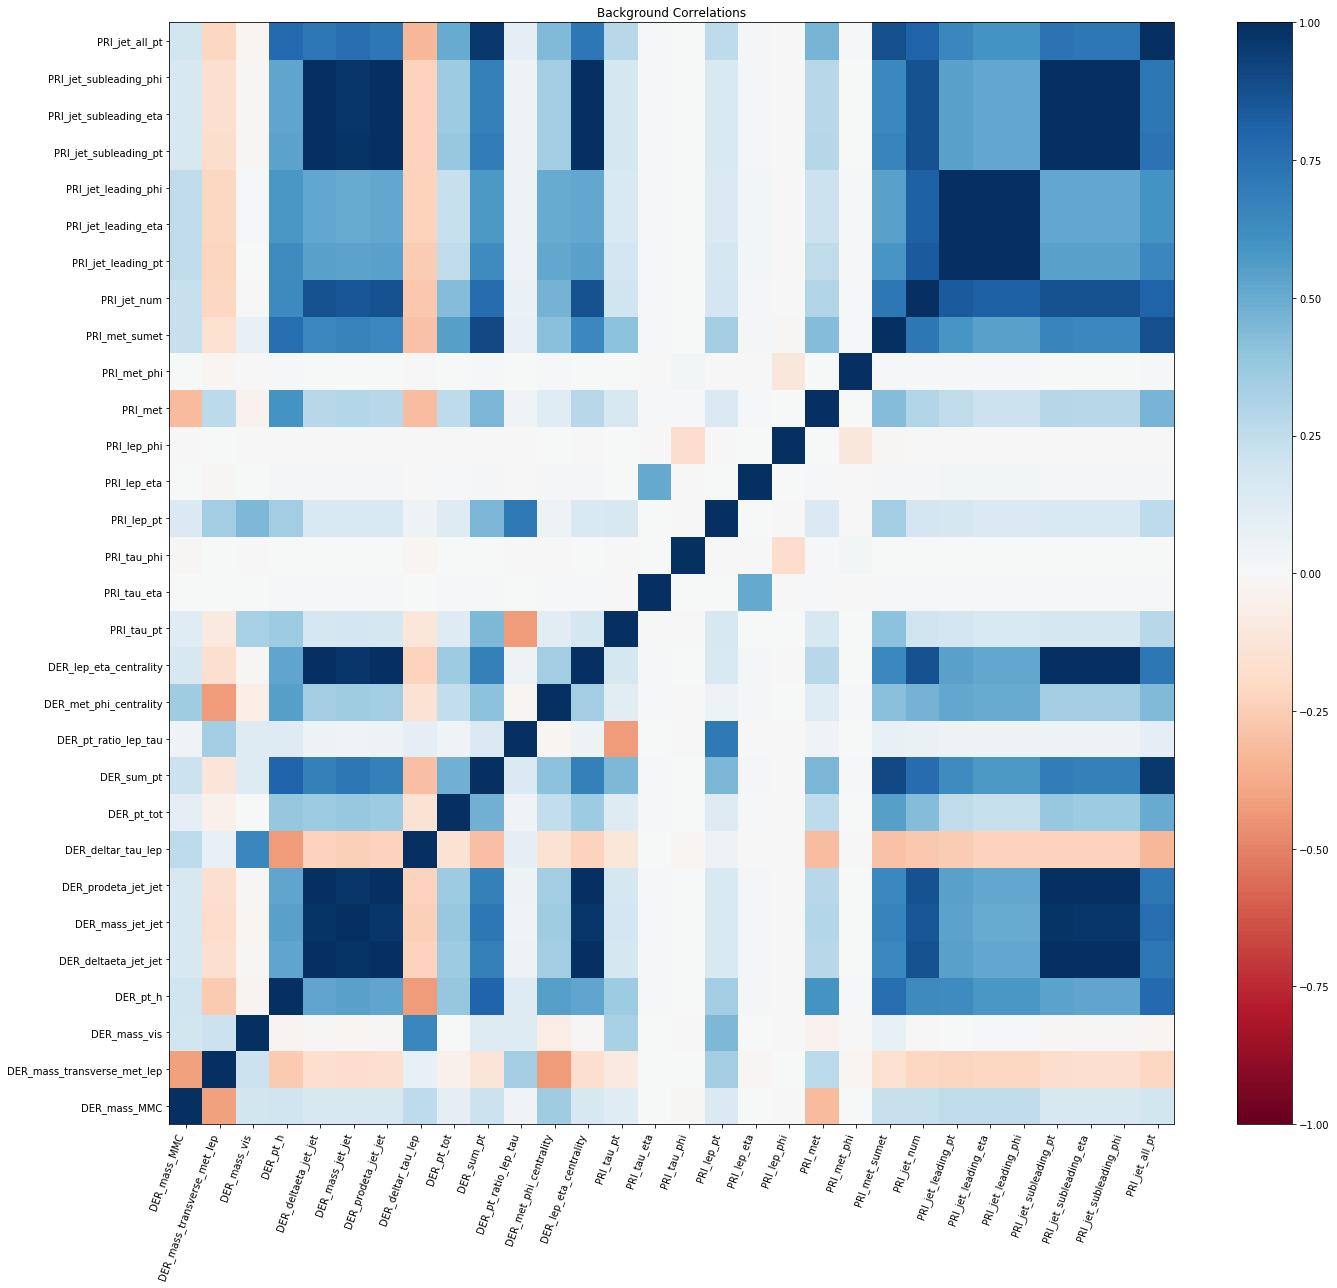

In [9]:
background_correlations()

Below is a function for training the model. 

First the data is read in using pandas built in csv reader. A filter is applied to select only certain features from the data and then the data is sorted into signal and background classes bassed on the values in the Label collumn. You should repurpose this code to help you wrangle the data into your own models.

This particular model is a DecisionTreeClassifier from scikit-learn bossted by an algorithm called AdaBoost (https://en.wikipedia.org/wiki/AdaBoost). We set some of the parameters for the classifier and the boosting algorithm but to see the full suite of options you should check the scikit-learn documentation.

We also call a function from the Tools file that will train the model. You can adapt this function for your own use.

Next a function from Plotting is called which uses matplotlib (https://matplotlib.org/) to plot the output score of model for the background and signal events respectively. Later on when we call the train function we will look at this plot in more detail.

Finally a call to the function dump is made. This function is from the library joblib (https://joblib.readthedocs.io/en/latest/) and will save our model to the file "example_sol.joblib".

In [10]:
def train():
    df = pd.read_csv("train.csv")

    df = df.filter(regex='DER_mass_MMC|DER_mass_transverse_met_lep|DER_pt_h|DER_deltar_tau_lep|DER_mass_vis|Label|Weight')

    sig = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="s") ].index ).drop('Label',axis=1)
    bkg = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="b") ].index ).drop('Label',axis=1)

    sig_weights = sig.Weight.values
    bkg_weights = bkg.Weight.values

    sig = sig.drop('Weight',axis=1)
    bkg = bkg.drop('Weight',axis=1)

    clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=4),
                             algorithm="SAMME",
                             n_estimators=200)


    Tools.train_mva(clf,sig,bkg,sig_weights,bkg_weights)

    Plotting.plot_output(clf,sig,bkg)

    dump(clf, "example_sol.joblib")
    
    return

Below is a function that tests our model.

First we read in the validation data and filter the same columns as before, except this time we don't have labels to load.

Then we use joblib's load function to load the model we saved earlier. It is very useful to be able to save your trained models to use later, that way you're not forced to use the model whilst it's still in memory.

The loaded classifier is then used to predict the labels of the validation sample. Those labels are stored into the array in the Label columm.

We sort the values in the array by the value of the decision function.

Lastly a simple for loop demonstrates how to present your models predictions so that we can properly evaluate how well your model performs in the challenge using the AMS score. Please ensure that whatever code you write outputs its submission files to the same specification as this for loop.

In [11]:
separation_array.sort()
print(separation_array)

NameError: name 'separation_array' is not defined

In [ ]:
def test():
    val = pd.read_csv("validation.csv")
    val = val.filter(regex='EventId|DER_mass_MMC|DER_mass_transverse_met_lep|DER_pt_h|DER_deltar_tau_lep|DER_mass_vis')

    clf = load("example_sol.joblib")

    eva = val.drop('EventId',axis=1)

    val['Label'] = clf.predict(eva.values)
    val['DF'] = clf.decision_function(eva.values)

    val = val.sort_values(by='DF',ascending=False).reset_index(drop=True)

    with open('validation_submission.csv','w') as f:
        f.write('EventId,RankOrder,Class\n')
        for index, row in val.iterrows():
            cls = 's' if row.Label == 1.0 else 'b'
            f.write(str(int(row.EventId)))
            f.write(',')
            f.write(str(index+1))
            f.write(',')
            f.write(cls)
            f.write('\n')
        f.close()

Let's run the train function and see what happens...

In [ ]:
%matplotlib notebook
train()

... that probably took a little while but hopefully not too long. Part of the challenge of building a machine learning model is designing something that will we give you results in a suitable timeframe. The timeframe for this challenge is to submit your solutions by 15:30 so you should bear this in mind when it comes to the complexity of your model. 

And look! Our plot appeared (hopefully!)

What can you learn from this plot. How are the signal and background events distributed as a function of the model score?

What would the output of a better model look like? And a worse one?

Next lets run the test function and produce the submission file.

In [ ]:
test()

You should be able to see the submission file in the same directory as this file. Take a look inside and make sure you understand the submission format so that you can correctly submit your solution later on!

Now it's time for you to start building your own model. Feel to use any code from this example to help you get started but also check the materials provided for more ideas.

Good luck! •ᴗ•